In [32]:
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
PW = 8
PH = 6
plt.rcParams['figure.figsize'] = (PW, PH) 
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_rows = 250
pd.options.display.max_columns = 250

from scipy.stats import norm, skew


dir_path = "./Meteorological Data/" 
%matplotlib inline

import os
print(os.listdir(dir_path))

['Melbourne - 086071-Table 1.csv', 'Brisbane - 040913-Table 1.csv', 'Adelaide - 023090-Table 1.csv', 'Perth - 009225-Table 1.csv', 'Sydney - 066062-Table 1.csv']


In [10]:
files = ['Melbourne - 086071-Table 1.csv', 'Brisbane - 040913-Table 1.csv',
         'Adelaide - 023090-Table 1.csv', 'Perth - 009225-Table 1.csv', 'Sydney - 066062-Table 1.csv']

In [28]:
df = pd.read_csv(dir_path + files[0], encoding="utf-8")

In [29]:
df.head(5)
print df.columns

Index([u'Date', u'Day', u'Minimum temperature (°C)',
       u'Maximum temperature (°C)', u'Rainfall (mm)', u'Evaporation (mm)',
       u'Sunshine (hours)', u'Direction of maximum wind gust ',
       u'Speed of maximum wind gust (km/h)', u'Time of maximum wind gust',
       u'9am Temperature (°C)', u'9am relative humidity (%)',
       u'9am cloud amount (oktas)', u'9am wind direction',
       u'9am wind speed (km/h)', u'9am MSL pressure (hPa)',
       u'3pm Temperature (°C)', u'3pm relative humidity (%)',
       u'3pm cloud amount (oktas)', u'3pm wind direction',
       u'3pm wind speed (km/h)', u'3pm MSL pressure (hPa)'],
      dtype='object')


In [30]:
#IsNan Cols
p = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
p = p[p > 0]
p

3pm cloud amount (oktas)             0.539379
9am cloud amount (oktas)             0.455847
Rainfall (mm)                        0.281623
3pm relative humidity (%)            0.121718
3pm Temperature (°C)                 0.119332
3pm MSL pressure (hPa)               0.116945
Maximum temperature (°C)             0.116945
Minimum temperature (°C)             0.114558
9am relative humidity (%)            0.114558
9am Temperature (°C)                 0.114558
9am MSL pressure (hPa)               0.114558
9am wind speed (km/h)                0.016706
3pm wind speed (km/h)                0.009547
Speed of maximum wind gust (km/h)    0.009547
Direction of maximum wind gust       0.009547
Time of maximum wind gust            0.002387
Sunshine (hours)                     0.002387
3pm wind direction                   0.002387
dtype: float64

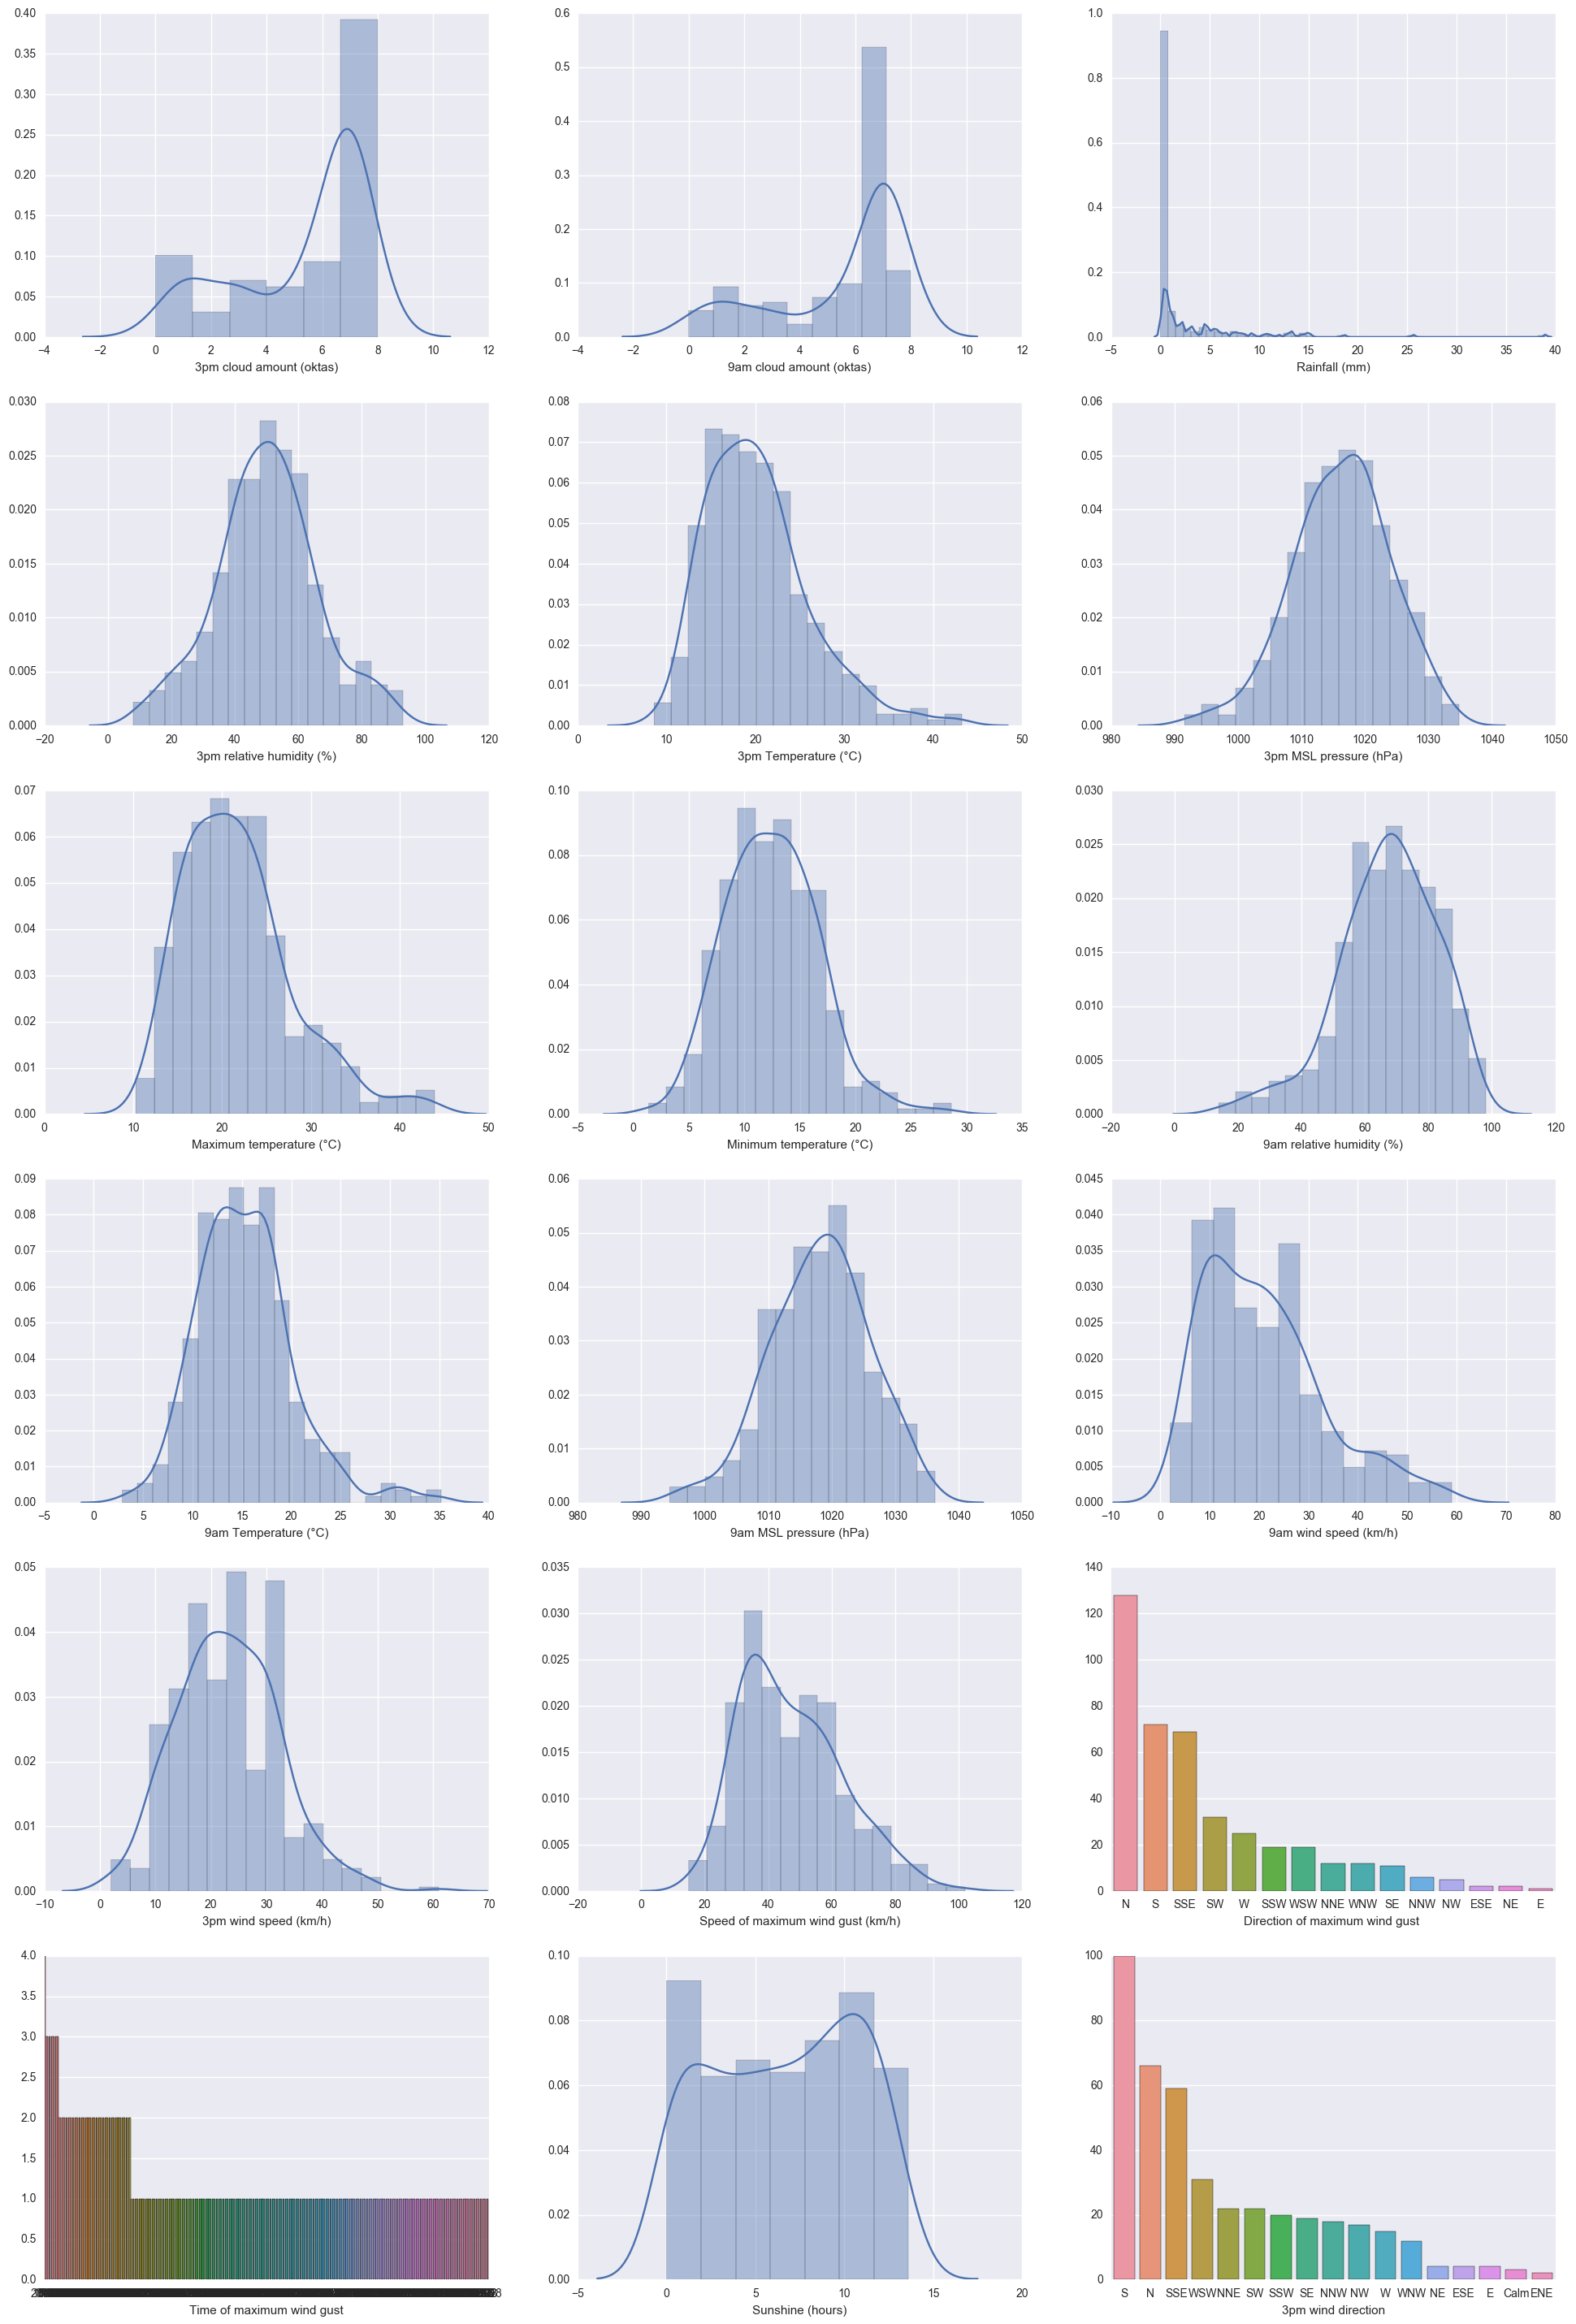

In [33]:
nrows = 3
ncols = int(np.ceil(len(p) / 3))
f, ax = plt.subplots(ncols, nrows, figsize=(nrows*PW,ncols*PH))
ind = 0
for col in p.index:
    if df[col].dtype == object:
        topl =  df[df[col].notnull()][col].value_counts()
        sns.barplot(x=np.array(topl.index), y= np.array(topl.values), ax=ax[int(ind/nrows),ind%nrows])
        ax[int(ind/nrows),ind%nrows].set_xlabel(col)
        ind += 1
    else:
        topl = df[df[col].notnull()][col]
        sns.distplot(topl, ax=ax[int(ind/nrows),ind%nrows])
        ind += 1